# Load Data

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

train_dir = '../input/herbarium-2022-fgvc9/train_images/'
test_dir = '../input/herbarium-2022-fgvc9/test_images/'

with open("../input/herbarium-2022-fgvc9/train_metadata.json") as json_file:
    train_meta = json.load(json_file)
with open("../input/herbarium-2022-fgvc9/test_metadata.json") as json_file:
    test_meta = json.load(json_file)

# JSON -> Dataframe

In [2]:
image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

test_ids = [image['image_id'] for image in test_meta]
test_dirs = [test_dir + image['file_name'] for image in test_meta]

#Create the initial training dataframe with the above defined columns
main_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

#Create a testing dataframe
Never_used = pd.DataFrame({
    "test_id" : test_ids,
    "test_dir" : test_dirs
})

main_df

,image_id,image_dir,category,genus
0,00000__001,../input/herbarium-2022-fgvc9/train_images/000...,0,1
1,00000__002,../input/herbarium-2022-fgvc9/train_images/000...,0,1
2,00000__003,../input/herbarium-2022-fgvc9/train_images/000...,0,1
3,00000__004,../input/herbarium-2022-fgvc9/train_images/000...,0,1
4,00000__005,../input/herbarium-2022-fgvc9/train_images/000...,0,1
...,...,...,...,...
839767,15504__032,../input/herbarium-2022-fgvc9/train_images/155...,15504,2584
839768,15504__033,../input/herbarium-2022-fgvc9/train_images/155...,15504,2584
839769,15504__035,../input/herbarium-2022-fgvc9/train_images/155...,15504,2584
839770,15504__036,../input/herbarium-2022-fgvc9/train_images/155...,15504,2584


# Mapping genus and family

In [ ]:
#Add a genus column to the dataframe
genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
main_df['genus'] = main_df['genus'].map(genus_map)

##Create a family column in the datagframe based on the genus names
    # Step 1: Create dictionary of genus -> family mapping
genus_family_map = {}
for category in train_meta["categories"]:
    genus = category['genus']
    family = category['family']
    genus_family_map[genus] = family

    # Step 2: Create new column with default value of None™
main_df['family'] = None

    # Step 3: Update values in new column based on genus -> family mapping
for i, row in main_df.iterrows():
    genus = row['genus']
    if genus in genus_family_map:
        family = genus_family_map[genus]
        main_df.at[i, 'family'] = family

main_df

# Filtering to Poaceae

In [ ]:
#Filter only the images of plants that are in the Poaceae family
main_df = main_df.loc[main_df['family'] == 'Poaceae']
#Reset index
main_df = main_df.reset_index(drop=True)

main_df

# Adding species column

In [ ]:
"""#Add category_id and species column
main_df["species"] = None

# Extract category_id and species values from categories where the family is Poaceae
species_list = []
for category in train_meta["categories"]:
    if category["family"] == "Poaceae":
        species_list.append({
            "category": category["category_id"],
            "species": category["species"]
        })

# loop through data frame and species list to update species column
for i, row in main_df.iterrows():
    for species in species_list:
        if row['category'] == species['category']:
            main_df.at[i, 'species'] = species['species']"""

# Data visualization

In [ ]:
genus_data = main_df['genus'].value_counts().head(15)
genus_data = pd.DataFrame({'Genus' : genus_data.index,
                     'values' : genus_data.values})
                     
plt.figure(figsize = (20, 10))
sns.barplot(x='values', y = 'Genus', data = genus_data , palette='summer_r')
plt.show()

#From most to least: Muhlenbergia, Paspalum, Poa, Dichanthelium, Sporobolus, Eragrostis etc.

# Filter to two genus

In [ ]:
#Muhlenbergia data
muh_pas_df = main_df[(main_df['genus'] == 'Paspalum') | (main_df['genus'] == 'Muhlenbergia')]
muh_pas_df = muh_pas_df.reset_index(drop=True)
muh_pas_df

# Image displaying

In [ ]:
def show_images(genus):
    images = main_df.loc[main_df['genus'] == genus]['image_dir'][:9]
    i = 1
    fig = plt.figure(figsize = (18, 18))
    plt.suptitle(genus, fontsize = '30')
    for image in images:
        img = cv2.imread(image)
        ax = fig.add_subplot(3, 3, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()

In [ ]:
show_images("Muhlenbergia")

In [ ]:
main_df["genus"].value_counts()

# Creating the model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from PIL import Image

!pip install fvcore

In [ ]:
main_df['genus'] = pd.factorize(main_df['genus'])[0]
main_df

In [ ]:
grouped = main_df.groupby('genus')
# Split the dataset for each class separately
train_dfs = []
test_dfs = []

for name, group in grouped:
    # Split the group into train and test sets
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    # Add the train and test dataframes to the respective lists
    train_dfs.append(train)
    test_dfs.append(test)

# Concatenate the training and evaluation sets for all classes into single DataFrames
train_df_initial = pd.concat(train_dfs)
train_df_initial = train_df_initial.reset_index(drop=True)

test_df = pd.concat(test_dfs)
test_df = test_df.reset_index(drop=True)

In [ ]:
grouped2 = train_df_initial.groupby('genus')
# Split the dataset for each class separately
train_dfs = []
val_dfs = []

for name, group in grouped2:
    # Split the group into train and test sets
    train, validation = train_test_split(group, test_size=0.2, random_state=42)
    # Add the train and test dataframes to the respective lists
    train_dfs.append(train)
    val_dfs.append(validation)

# Concatenate the training and evaluation sets for all classes into single DataFrames
train_df = pd.concat(train_dfs)
train_df = train_df.reset_index(drop=True)

val_df = pd.concat(val_dfs)
val_df = val_df.reset_index(drop=True)

In [ ]:
batch_size = 128
epochs = 4
IM_SIZE = 224
learning_rate = 1e-4

X_train, Y_train = train_df["image_dir"].values, train_df["genus"].values

X_val, Y_val = val_df["image_dir"].values, val_df["genus"].values

X_test, Y_test  = test_df["image_dir"].values, test_df["genus"].values

Transform = transforms.Compose([
     transforms.Resize((IM_SIZE, IM_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(self.fnames[index])
    
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
        
        
class GetTestData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(self.fnames[index])
        return self.transform(x), self.labels[index]

        
trainset = GetData(X_train, Y_train, Transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

valset = GetData(X_val, Y_val, Transform)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

testset = GetTestData(X_test, Y_test, Transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest101', pretrained=True)            

In [ ]:
num_classes = train_df['genus'].nunique()
print(num_classes)

In [ ]:
total_layers = len(list(model.parameters()))

for param in model.parameters():
    param.requires_grad = True
    
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, num_classes)
model.fc = last_layer 
if torch.cuda.is_available():
    model.cuda()
print(model.fc.out_features)    

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device("cpu")):
    train_acc = 0.0
    train_loss = 0.0
    y_true = []
    y_pred = []
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            acc = ((output.argmax(dim=1) == labels).float().mean())
            train_acc += acc
            train_loss += loss
            y_true += labels.cpu().numpy().tolist()
            y_pred += output.argmax(dim=1).cpu().numpy().tolist()
            
    train_f1 = f1_score(y_true, y_pred, average=None)
    train_f1_avg = f1_score(y_true, y_pred, average='macro')
    return train_acc/len(trainloader), train_loss/len(trainloader), train_f1, train_f1_avg

In [ ]:
def evaluate(testloader, model, criterion, device=torch.device("cpu")):
    model.eval()
    eval_acc = 0.0
    eval_loss = 0.0
    y_true = []
    y_pred = []
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        y_true += labels.cpu().numpy().tolist()
        y_pred += output.argmax(dim=1).cpu().numpy().tolist()
  
    eval_f1 = f1_score(y_true, y_pred, average=None)
    eval_f1_avg = f1_score(y_true, y_pred, average='macro')
    return eval_acc/len(testloader), eval_loss/len(testloader), eval_f1, eval_f1_avg

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

train_f1_scores = []  # Initialize an empty list to store training F1 scores
val_f1_scores = []  # Initialize an empty list to store validation F1 scores


for epoch in range(epochs):
    train_acc, train_loss, train_f1, train_f1_avg = train(trainloader, model, criterion, optimizer, scaler, device=device)
    eval_acc, eval_loss, eval_f1, eval_f1_avg = evaluate(valloader, model, criterion, device=torch.device("cuda"))

    train_f1_scores.append(train_f1_avg)  # Store the training F1 score for this epoch
    val_f1_scores.append(eval_f1_avg)  # Store the validation F1 score for this epoch

    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss} | Train F1 (Avg): {train_f1_avg}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss} | Val F1 (Avg): {eval_f1_avg}")
    
    print("F1 score per class (Train):")
    for i, f1 in enumerate(train_f1):
        print(f"Class {i}: {f1}")

    print("\nF1 score per class (Validation):") 
    for i, f1 in enumerate(eval_f1):
        print(f"Class {i}: {f1}")

    print("===="*8)

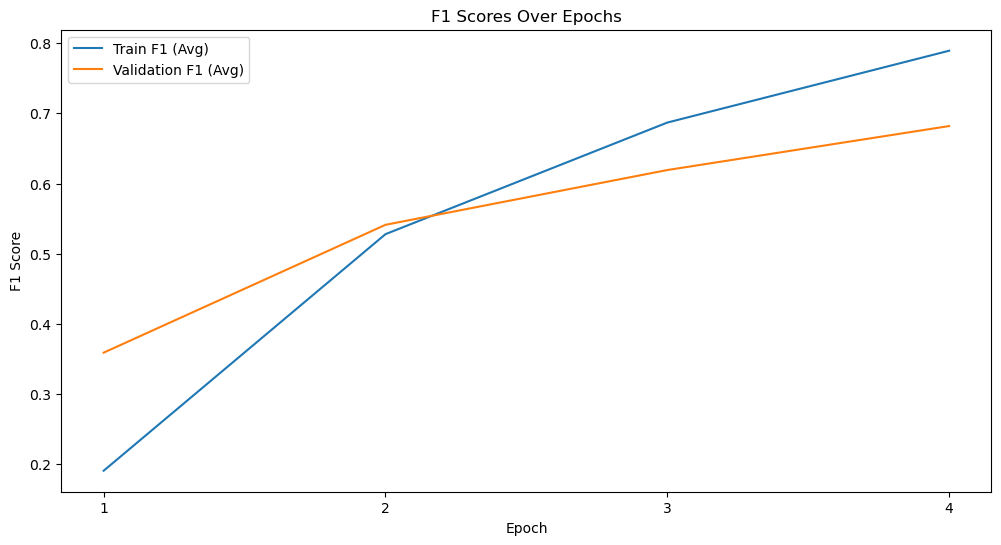

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_f1_scores, label="Train F1 (Avg)")
plt.plot(val_f1_scores, label="Validation F1 (Avg)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title(f"F1 Scores Over Epochs")
plt.legend()
plt.xticks(range(len(train_f1_scores)), range(1, len(train_f1_scores) + 1))
plt.show()

In [59]:
# Assume that the `testloader` DataLoader has been created for the test set
test_acc = 0.0
y_true = []
y_pred = []

model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Loop through the test set
with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        # Make predictions
        output = model(images)

        # Calculate accuracy
        acc = (output.argmax(dim=1) == labels).float().mean()
        test_acc += acc

        # Store true labels and predicted labels for other metrics
        y_true += labels.cpu().numpy().tolist()
        y_pred += output.argmax(dim=1).cpu().numpy().tolist()

# Calculate the final test accuracy
test_acc = test_acc / len(testloader)
print(f"Test accuracy: {test_acc:.2%}")

# Calculate the classification report, which includes the F1 score for all classes
report = classification_report(y_true, y_pred, output_dict=True)

# Print the classification report
for class_label, metrics in report.items():
    if class_label.isdigit():
        print(f"Class {class_label}: F1 score = {metrics['f1-score']:.2f}")

Testing: 100%|██████████| 85/85 [04:30<00:00,  3.18s/it]

Test accuracy: 0.13%
Class 0: F1 score = 0.00
Class 1: F1 score = 0.00
Class 2: F1 score = 0.00
Class 3: F1 score = 0.00
Class 4: F1 score = 0.00
Class 5: F1 score = 0.00
Class 6: F1 score = 0.00
Class 7: F1 score = 0.00
Class 8: F1 score = 0.00
Class 9: F1 score = 0.00
Class 10: F1 score = 0.00
Class 11: F1 score = 0.00
Class 12: F1 score = 0.00
Class 13: F1 score = 0.00
Class 14: F1 score = 0.00
Class 15: F1 score = 0.00
Class 16: F1 score = 0.00
Class 17: F1 score = 0.00
Class 18: F1 score = 0.00
Class 19: F1 score = 0.00
Class 20: F1 score = 0.00
Class 21: F1 score = 0.00
Class 22: F1 score = 0.00
Class 23: F1 score = 0.00
Class 24: F1 score = 0.00
Class 25: F1 score = 0.00
Class 26: F1 score = 0.00
Class 27: F1 score = 0.00
Class 28: F1 score = 0.00
Class 29: F1 score = 0.00
Class 30: F1 score = 0.00
Class 31: F1 score = 0.00
Class 32: F1 score = 0.00
Class 33: F1 score = 0.00
Class 34: F1 score = 0.00
Class 35: F1 score = 0.00
Class 36: F1 score = 0.00
Class 37: F1 score = 0.00
C


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:

In [60]:
"""scaler = torch.cuda.amp.GradScaler(enabled=True)

val_f1_scores = []  # Initialize an empty list to store validation F1 scores

eval_acc, eval_loss, eval_f1, eval_f1_avg = evaluate(testloader, model, criterion, device=torch.device("cuda"))

val_f1_scores.append(eval_f1_avg)  # Store the validation F1 score for this epoch

print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss} | Val F1 (Avg): {eval_f1_avg}")

print("\nF1 score per class (Validation):") 
for i, f1 in enumerate(eval_f1):
    print(f"Class {i}: {f1}")

print("===="*8)"""

100%|██████████| 85/85 [04:19<00:00,  3.05s/it]

	 Val Acc: 0.12867647409439087 | Val Loss: 8.45955753326416 | Val F1 (Avg): 0.00012164442323680028

F1 score per class (Validation):
Class 0: 0.0
Class 1: 0.0
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
Class 12: 0.0
Class 13: 0.0
Class 14: 0.0
Class 15: 0.0
Class 16: 0.0
Class 17: 0.0
Class 18: 0.0
Class 19: 0.0
Class 20: 0.0
Class 21: 0.0
Class 22: 0.0
Class 23: 0.0
Class 24: 0.0
Class 25: 0.0
Class 26: 0.0
Class 27: 0.0
Class 28: 0.0
Class 29: 0.0
Class 30: 0.0
Class 31: 0.0
Class 32: 0.0
Class 33: 0.0
Class 34: 0.0
Class 35: 0.0
Class 36: 0.0
Class 37: 0.0
Class 38: 0.0
Class 39: 0.0
Class 40: 0.0
Class 41: 0.0
Class 42: 0.0
Class 43: 0.0
Class 44: 0.0
Class 45: 0.0
Class 46: 0.0
Class 47: 0.0
Class 48: 0.0
Class 49: 0.0
Class 50: 0.0
Class 51: 0.0
Class 52: 0.0
Class 53: 0.0
Class 54: 0.0
Class 55: 0.0
Class 56: 0.0
Class 57: 0.0
Class 58: 0.0
Class 59: 0.0
Class 60: 0.0
Class 61: 0.0
Class 62: